<h1>Problem statement</h1>

<h2> Governing equations </h2>
<h4> Continuity equation: </h4>
<br>
<br>$$\frac{\partial u}{\partial x}+\frac{\partial w}{\partial z}=0$$<br>
<h4> Momentum conservation in x direction: </h4>
<br>
$$u\frac{\partial u}{\partial x}+w\frac{\partial u}{\partial z}
= \frac{-1}{\rho} \frac{\partial p}{\partial x} + \nu_{total}(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial z^2})$$<br>
<h4> Momentum conservation in z direction: </h4>
<br>
$$u\frac{\partial w}{\partial x}+w\frac{\partial w}{\partial z}
= \frac{-1}{\rho} \frac{\partial p}{\partial z} + \nu_{total}(\frac{\partial^2 w}{\partial x^2}+\frac{\partial^2 w}{\partial z^2})$$<br>
<h4> Spalart-Allmaras Turbulence model </h4>
$$U\frac{\partial \tilde{\nu}}{\partial x}+V\frac{\partial \tilde{\nu}}{\partial z} = 
C_{b1}\tilde{S}\tilde{\nu}-C_{w1}f_{w}(\frac{\tilde{\nu}}{d})^2+
\frac{1}{\sigma}[\frac{\partial (\nu+\tilde{\nu})}{\partial x}\frac{\partial \tilde{\nu}}{\partial x}+
\frac{\partial (\nu+\tilde{\nu})}{\partial z}\frac{\partial \tilde{\nu}}{\partial z}]+
C_{b2}[\frac{\partial \tilde{\nu}}{\partial x}\frac{\partial \tilde{\nu}}{\partial x}+
\frac{\partial \tilde{\nu}}{\partial z}\frac{\partial \tilde{\nu}}{\partial z}]$$
where d is the distance to the closest wall, i.e. d = z
<br>
<br>

<h2>Loss function</h2>
$$ Loss_{total} = \lambda_1 Loss_{BC} + \lambda_2 Loss_{RANS} + \lambda_3 Loss_{sample}$$

Missing viscosity $\nu$ value?
<br>
Time averaged viscosity?
<br>
Correct $\omega_{ij}$ formula?

<h2> Boundary condition </h2>
<h4> No-slip condition: </h4>
$$ u(x,0) = 0 $$
<h4> Impermeability </h4>
$$ w(x,0) = 0 $$
<h4> Inlet velocity specification</h4>
<h4> Outlet velocity specification</h4>

<h2> Assumptions </h2>
density set to average

In [1]:
import torch
from torch import nn
from torch import autograd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from pyDOE import lhs         #Latin Hypercube Sampling

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
# torch.manual_seed(1234)

# Random number generators in other libraries
# np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

C:\Users\Cyrus\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


# Data explore

In [2]:
df = pd.read_csv("../Data/ChannelFlow.csv")
df = df[df["time"]==df["time"].max()]
df.head()

,time,x,y,u,v
720896,937.5,0.007812,0.007812,0.014101,0.0
720897,937.5,0.007812,0.023438,0.041816,0.0
720898,937.5,0.007812,0.039062,0.069045,0.0
720899,937.5,0.007812,0.054688,0.095791,0.0
720900,937.5,0.007812,0.070312,0.122055,0.0


In [3]:
df.shape

(65536, 5)

In [4]:
## Coordinates
x = torch.tensor(df["x"].values).view(-1,1)
z = torch.tensor(df["y"].values).view(-1,1)
U = torch.tensor(df["u"].values).view(-1,1)
W = torch.tensor(df["v"].values).view(-1,1)

<h2>Data visualisation</h2>

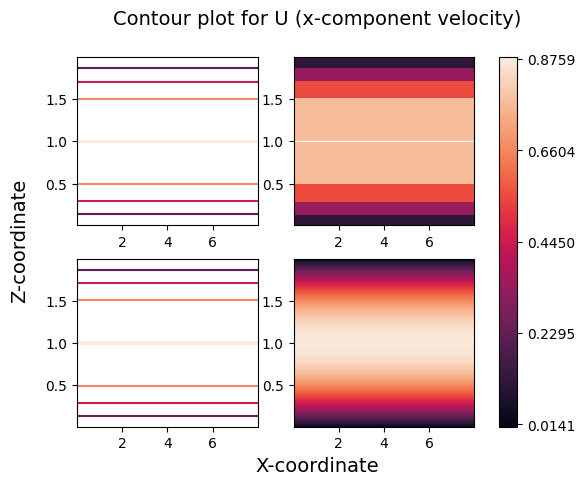

In [5]:
fig, ax = plt.subplots(2,2)
cmap_U = []
levels_U = np.linspace(torch.min(U),torch.max(U),5) # Contour levels

# Overview
cmap_U.append(ax[0,0].tricontour(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U,cmap=sns.cm.rocket))
cmap_U.append(ax[0,1].tricontourf(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U,cmap=sns.cm.rocket))

# Boundary layer initiation (zoomed in version)
cmap_U.append(ax[1,0].tricontour(x.squeeze(),z.squeeze(),U.squeeze(),levels=levels_U,cmap=sns.cm.rocket))
cmap_U.append(ax[1,1].tricontourf(x.squeeze(),z.squeeze(),U.squeeze(),levels=121,cmap=sns.cm.rocket))


# Figure format
fig.suptitle("Contour plot for U (x-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
# for i in range(len(cmap_U)):
#     fig.colorbar(cmap_U[i],ticks=levels_U)
fig.colorbar(cmap_U[3],ax=ax.ravel().tolist(),ticks=levels_U)
plt.show()

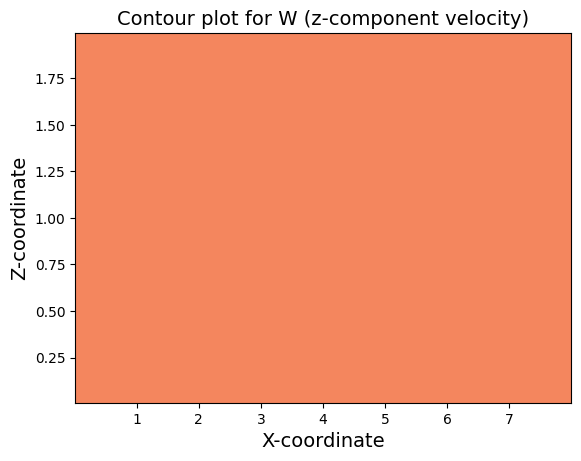

In [6]:
plt.tricontourf(x.squeeze(),z.squeeze(),W.squeeze(),cmap=sns.cm.rocket,levels=121)

# Figure format
plt.title("Contour plot for W (z-component velocity)",fontsize=14)
plt.xlabel("X-coordinate",fontsize=14)
plt.ylabel("Z-coordinate",fontsize=14)
plt.show()

# Feature engineering

<h2> Parameters </h2>

In [7]:
# Sampling
N_BC = 100
N_RANS = 1000
N_sample = 50

# PINN
layers = [2,32,64,64,32,2]
lr = 1e-4
steps=10000
iterations = 5000 # Adam

# Governing equation
nu_laminar = 1.562e-5
density = 1.
viscosity = 1e-3  # kinematic visocity
pressure_gradient = 2e-3  # uniform dP/dx


<h2> Test set </h2>

In [8]:
# All data available
x_test = torch.hstack([x,z]) # The coordinates
y_test = torch.hstack([U,W]) # Flow parameters

<h2>Feature scaling</h2>

In [9]:
# Domain range
x_lb,x_ub,z_lb,z_ub = torch.min(x_test[:,0]),torch.max(x_test[:,0]),torch.min(x_test[:,1]),torch.max(x_test[:,1])
# Velocity range
U_lb,U_ub,W_lb,W_ub = torch.min(y_test[:,0]),torch.max(y_test[:,0]),torch.min(y_test[:,1]),torch.max(y_test[:,1])

print("minimum x-coordinate : ",x_lb.numpy(),"maximum x-coordinate : ",x_ub.numpy())
print("minimum z-coordinate : ",z_lb.numpy(),"maximum z-coordinate : ",z_ub.numpy())
print("minimum U (x-coordinate velocity) : ",U_lb.numpy(),"maximum U (x-coordinate velocity) : ",U_ub.numpy())
print("minimum W (z-coordinate velocity) : ",W_lb.numpy(),"maximum W (z-coordinate velocity) : ",W_ub.numpy())

minimum x-coordinate :  0.0078125 maximum x-coordinate :  7.9921875
minimum z-coordinate :  0.0078125 maximum z-coordinate :  1.9921875
minimum U (x-coordinate velocity) :  0.014101027 maximum U (x-coordinate velocity) :  0.8758515
minimum W (z-coordinate velocity) :  0.0 maximum W (z-coordinate velocity) :  0.0


In [10]:
class TorchStandardScaler():
    def __init__(self):
        self.mean = 0
        self.sd = 0
        self.fitted = False
        
    def fit(self,input_tensor):
        self.mean = torch.mean(input_tensor,0)
        self.std = torch.std(input_tensor,0)
        
    def transform(self,input_tensor):
        input_tensor[:,0] = (input_tensor[:,0]-self.mean[0])/self.std[0]
        return input_tensor
    
    def inverse_transform(self,input_tensor):
        input_tensor[:,0] =  input_tensor[:,0]*self.std[0]+self.mean[0]
        return input_tensor

In [11]:
scaler = TorchStandardScaler()
scaler.fit(y_test)
y_test = scaler.transform(y_test)

# Train set

In [12]:
## Note testing set is unscaled 
# Boundary condition

# At the wall
wall_mask = (x_test[:,0]>=0).numpy() & ( (x_test[:,1]==z_lb).numpy() | (x_test[:,1]==z_ub).numpy() ) # x >= 0 and (z = -1 or z = 1)
x_train_wall = x_test[wall_mask]
y_train_wall = y_test[wall_mask]
print("x_train_wall shape : ",x_train_wall.shape,"y_train_wall shape : ",y_train_wall.shape)

# Inlet
inlet_mask = (x_test[:,0]==x_lb).numpy() # x = 0
x_train_inlet = x_test[inlet_mask]
y_train_inlet = y_test[inlet_mask]
print("x_train_inlet shape : ",x_train_inlet.shape,"y_train_inlet shape : ",y_train_inlet.shape)

# Outlet
outlet_mask = (x_test[:,0]==x_ub).numpy() # x = 8
x_train_outlet = x_test[outlet_mask]
y_train_outlet = y_test[outlet_mask]
print("x_train_outlet shape : ",x_train_outlet.shape,"y_train_outlet shape : ",y_train_outlet.shape)

# Boundary condition data set
x_train_BC = torch.vstack([x_train_wall,x_train_inlet,x_train_outlet])
y_train_BC = torch.vstack([y_train_wall,y_train_inlet,y_train_outlet])
# Shuffling
idx_BC = np.random.choice(x_train_BC.shape[0],size=N_BC,replace=False)
x_train_BC = x_train_BC[idx_BC,:]
y_train_BC = y_train_BC[idx_BC,:]
print("x_train_BC shape : ",x_train_BC.shape,"y_train_BC shape : ",y_train_BC.shape)

# Collocation points (Full RANS equation)
lower_bound = torch.hstack([x_lb,z_lb])
upper_bound = torch.hstack([x_ub,z_ub])
x_train_RANS = lower_bound + (upper_bound-lower_bound)*lhs(2,samples=N_RANS)
x_train_RANS = torch.vstack([x_train_RANS,x_train_BC])
print("x_train_RANS shape : ",x_train_RANS.shape)

# Sample points from dataset
idx_sample = np.random.choice(x_test.shape[0],size=N_sample,replace=False)
x_train_sample = x_test[idx_sample,:]
y_train_sample = y_test[idx_sample,:]
print("x_train_sample shape : ",x_train_sample.shape,"y_train_sample shape : ",y_train_sample.shape)

x_train_wall shape :  torch.Size([1024, 2]) y_train_wall shape :  torch.Size([1024, 2])
x_train_inlet shape :  torch.Size([128, 2]) y_train_inlet shape :  torch.Size([128, 2])
x_train_outlet shape :  torch.Size([128, 2]) y_train_outlet shape :  torch.Size([128, 2])
x_train_BC shape :  torch.Size([100, 2]) y_train_BC shape :  torch.Size([100, 2])
x_train_RANS shape :  torch.Size([1100, 2])
x_train_sample shape :  torch.Size([50, 2]) y_train_sample shape :  torch.Size([50, 2])


<h2> Load data to GPU </h2>

In [13]:
# Boundary condition
X_train_BC = (x_train_BC).float().to(device)
Y_train_BC = (y_train_BC).float().to(device)

# Internal sampling
X_train_sample = (x_train_sample).float().to(device)
Y_train_sample = (y_train_sample).float().to(device)

# Governing equation (RANS equation)
X_train_RANS = (x_train_RANS).float().to(device)
RANS_hat = torch.zeros(X_train_RANS.shape[0],1).float().to(device) # Zero

# Testing
X_test = (x_test).to(device)
Y_test = (y_test).float().to(device)

print("RANS_hat shape : ",RANS_hat.shape)

RANS_hat shape :  torch.Size([1100, 1])


# Machine learning model

<h2> Physics Informed Neural Network </h2>

In [14]:
class PINN(nn.Module):
    def __init__(self,layers):
        super().__init__() # initialising the parent class
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction="mean")
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        # Weight and bias initalisation
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data) # All bias set to zero
            
    # Forward passes
    def forward(self,x):
        if torch.is_tensor(x) != True:
            a = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        # learned features
        a = self.linears[-1](a) # no activation function
        return a
    
    # Boundary condition
    def loss_inlet(self,x_inlet,y_inlet):
        g = x_inlet.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        f = f_raw

        loss_inlet_velocity_u = self.loss_function(f[:,0],y_inlet[:,0])
        loss_inlet_velocity_v = self.loss_function(f[:,1],y_inlet[:,1])
        
        return loss_inlet_velocity_u + loss_inlet_velocity_v


    def loss_outlet(self,x_outlet,y_outlet):
        f_raw = self.forward(x_outlet)
        f = f_raw
        
        loss_outlet_velocity_u = self.loss_function(f[:,0],y_outlet[:,0])
        loss_outlet_velocity_v = self.loss_function(f[:,1],y_outlet[:,1])
        
        return loss_outlet_velocity_u + loss_outlet_velocity_v
    
    def loss_wall(self,x_wall,y_wall):
        g = x_wall.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        f = f_raw
        loss_no_slip = self.loss_function(f,y_wall)
        
        return loss_no_slip # loss_no_slip_x + loss_no_slip_z
        
    def loss_RANS(self, x_RANS):
        g = x_RANS.clone()
        g.requires_grad = True
        f_raw = self.forward(g)
        # f = f_raw
        
        f = (scaler.inverse_transform(f_raw))
        U_xz = autograd.grad(f[:,0][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        U_xx_zz = autograd.grad(U_xz,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        U_x = U_xz[:,[0]]
        U_z = U_xz[:,[1]]
        U_xx = U_xx_zz[:,[0]]
        U_zz = U_xx_zz[:,[1]]
        W_xz = autograd.grad(f[:,1][:,None],g,torch.ones([g.shape[0], 1]).to(device),retain_graph=True,create_graph=True)[0]
        W_xx_zz = autograd.grad(W_xz,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        W_x = W_xz[:,[0]]
        W_z = W_xz[:,[1]]      
        W_xx = W_xx_zz[:,[0]]
        W_zz = W_xx_zz[:,[1]]
   
        # nu_eddy = nu_tilde_to_eddy(f[:,[3]])
        # nu = nu_eddy + nu_laminar
        
        #################### RANS #######################
        RANS_continuity = U_x + W_z
        
        RANS_momentum_x = ((f[:,[0]].float()*U_x + f[:,[1]].float()*U_z 
                           + 1/(density)*pressure_gradient - viscosity*(U_xx+U_zz)))
        
        RANS_momentum_z = ((f[:,[0]].float()*W_x + f[:,[1]].float()*W_z 
                            + 1/(density)*0 - viscosity*(W_xx+W_zz)))
        #################### RANS #######################
        
        lambda_continuity, lambda_x, lambda_z = 1, 1, 1
        loss_continuity = self.loss_function(RANS_continuity,RANS_hat)
        loss_momentum_x = self.loss_function(RANS_momentum_x,RANS_hat)
        loss_momentum_z = self.loss_function(RANS_momentum_z,RANS_hat)
        
        return loss_continuity*lambda_continuity + loss_momentum_x*lambda_x + loss_momentum_z*lambda_z
    
    # Sample points
    def loss_sample(self,x_train_sample,y_train_sample):
        f_raw = self.forward(x_train_sample)
        f = f_raw
        
        loss_sampling = self.loss_function(f,y_train_sample)
        
        return loss_sampling
    
    # Boundary condition (wrapper function)
    def loss_BC(self,x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet):
        return self.loss_wall(x_PINN_wall,y_PINN_wall) + self.loss_inlet(x_PINN_inlet,y_PINN_inlet) + self.loss_outlet(x_PINN_outlet,y_PINN_outlet)
    
    def loss(self,mode,x_train_BC,y_train_BC,x_train_RANS,x_train_sample,y_train_sample):
        # At wall
        wall_mask = (x_train_BC[:,0]>=0).numpy() & ( (x_train_BC[:,1]==z_lb).numpy() | (x_train_BC[:,1]==z_ub).numpy() )
        x_PINN_wall = x_train_BC[wall_mask]
        y_PINN_wall = y_train_BC[wall_mask]
        
        # At inlet
        inlet_mask = (x_train_BC[:,0]==x_lb).numpy()
        x_PINN_inlet = x_train_BC[inlet_mask]
        y_PINN_inlet = y_train_BC[inlet_mask]
        
        # At outlet
        outlet_mask = (x_train_BC[:,0]==x_ub).numpy()
        x_PINN_outlet = x_train_BC[outlet_mask]
        y_PINN_outlet = y_train_BC[outlet_mask]
        
        lambda1, lambda2, lambda3, lambda4 = 1, 1, 1, 1

        if mode == 0:
            return (self.loss_RANS(x_train_RANS)*lambda1
                    + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   # )
        elif mode == 1:
            return (#self.loss_RANS(x_train_RANS)*lambda1
                    # + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   # )
        elif mode == 2:
            return (#self.loss_RANS(x_train_RANS)*lambda1
                    + self.loss_BC(x_PINN_wall,y_PINN_wall,x_PINN_inlet,y_PINN_inlet,x_PINN_outlet,y_PINN_outlet)*lambda3
                    # + self.loss_sample(x_train_sample,y_train_sample)*lambda4)
                   )
        else:
            return 0
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()   
#         
        loss = self.loss(X_train_BC,Y_train_BC,X_train_RANS,X_train_sample,Y_train_sample)
#         
        loss.backward()
        self.iter += 1
        
        if self.iter % 50 == 0:
            test_loss = self.loss_function(scaler.inverse_transform(self.forward(X_test)),scaler.inverse_transform(Y_test))*0.01

        return loss  

<h2> Neural Network summary </h2>

In [15]:
Model = PINN(layers)
Model.float().to(device)
print(Model)

PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [16]:
Model.loss(0,X_train_BC,Y_train_BC,X_train_RANS,X_train_sample,Y_train_sample)

tensor(4.1626, grad_fn=<AddBackward0>)

<h2> Model training </h2>

In [17]:
history = torch.zeros(iterations,2)
optimizer = torch.optim.Adam(Model.parameters(),lr=lr,amsgrad=False)
for i in range(iterations):
    loss = Model.loss(0,X_train_BC,Y_train_BC,X_train_RANS,X_train_sample,Y_train_sample)
    history[i,:] = torch.tensor([i,loss])
    # for linear in Model.linears:
    #     print("Parameters",(linear.weight))
    #     print("Gradient",(linear.weight.grad))
    
    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(Model.parameters(), 0)
    optimizer.step()
    if i % 250 ==0:
        with torch.no_grad():
            test_loss = Model.loss_function(Model(X_test),Y_test)
        print(i,"Training loss :",np.round(loss.detach().cpu().numpy(),7),
              "Testing loss :",np.round(test_loss.detach().cpu().numpy(),7),
             "RANS loss :",np.round(Model.loss_RANS(X_train_RANS).detach().cpu().numpy()*1,7),
             "BC loss :",np.round(Model.loss_function(Model(X_train_BC)[:,0:2],Y_train_BC[:,0:2]).detach().cpu().numpy(),7),
             "Sample loss :",np.round(Model.loss_sample(X_train_sample,Y_train_sample).detach().cpu().numpy(),7))

0 Training loss : 4.162636 Testing loss : 0.6395022 RANS loss : 0.0155896 BC loss : 1.5028387 Sample loss : 0.684037
250 Training loss : 2.7400036 Testing loss : 0.932709 RANS loss : 0.0184852 BC loss : 0.7289358 Sample loss : 0.910055
500 Training loss : 0.8575468 Testing loss : 0.3716153 RANS loss : 0.0150553 BC loss : 0.2240906 Sample loss : 0.3417835
750 Training loss : 0.1191222 Testing loss : 0.0454836 RANS loss : 0.0042584 BC loss : 0.0297153 Sample loss : 0.0397311
1000 Training loss : 0.0617269 Testing loss : 0.0224288 RANS loss : 0.0039615 BC loss : 0.0140906 Sample loss : 0.0212361
1250 Training loss : 0.0389111 Testing loss : 0.0140447 RANS loss : 0.0032003 BC loss : 0.008882 Sample loss : 0.0138096
1500 Training loss : 0.0260056 Testing loss : 0.0091114 RANS loss : 0.0024164 BC loss : 0.0059964 Sample loss : 0.0089687
1750 Training loss : 0.0178123 Testing loss : 0.0060202 RANS loss : 0.0017959 BC loss : 0.0041952 Sample loss : 0.0058665
2000 Training loss : 0.0124087 Test

Text(0, 0.5, 'Training loss')

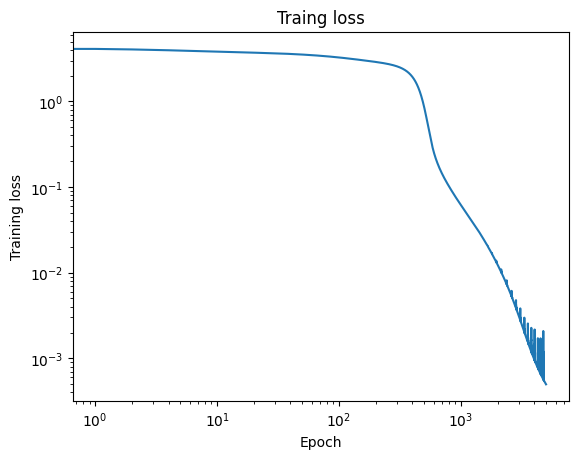

In [18]:
plt.plot(history[:,0],history[:,1])
plt.xscale('log')
plt.yscale('log')
plt.title("Traing loss")
plt.xlabel("Epoch")
plt.ylabel("Training loss")

<h1>Result visualisation</h1>

In [19]:
y_pred = Model(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

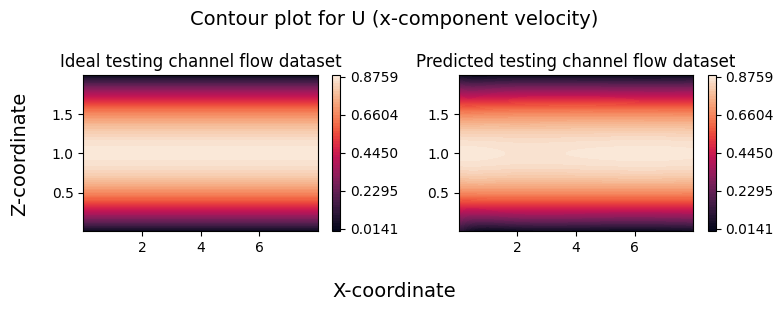

In [20]:
fig, ax = plt.subplots(1,2)
cmap = []
levels_U = np.linspace(torch.min(U),torch.max(U),5) # Contour levels

# Overview
cmap.append(ax[0].tricontourf(x_test[:,0].squeeze(),x_test[:,1].squeeze(),y_test[:,0].squeeze(),levels=75,cmap=sns.cm.rocket))

# Boundary layer initiation (zoomed in version)
cmap.append(ax[1].tricontourf(x_test[:,0].squeeze(),x_test[:,1].squeeze(),y_pred[:,0].detach().numpy().squeeze(),levels=75,cmap=sns.cm.rocket))

# Ax format
ax[0].set_title("Ideal testing channel flow dataset")
ax[1].set_title("Predicted testing channel flow dataset")

# Figure format
fig.suptitle("Contour plot for U (x-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
fig.set_size_inches(8, 3)
for i in range(len(cmap)):
    fig.colorbar(cmap[i],ticks=levels_U)
# fig.colorbar(cmap_U[0],ax=ax.ravel().tolist(),ticks=levels_U)
plt.tight_layout()
plt.show()

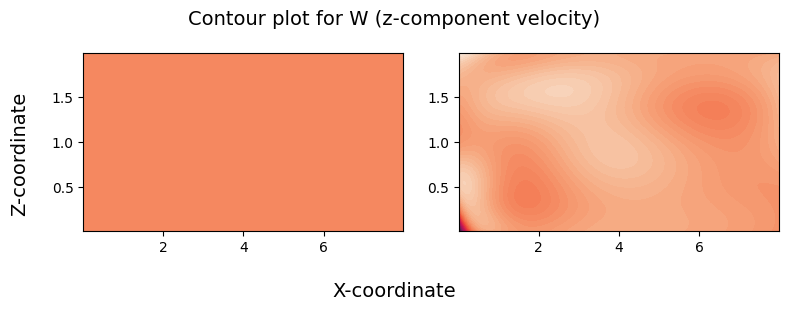

In [21]:
fig, ax = plt.subplots(1,2)
cmap_W = []
levels_U = np.linspace(torch.min(W),torch.max(W),75) # Contour levels

# Overview
cmap_W.append(ax[0].tricontourf(x_test[:,0].squeeze(),x_test[:,1].squeeze(),y_test[:,1].squeeze(),levels=75,cmap=sns.cm.rocket))

# Boundary layer initiation (zoomed in version)
cmap_W.append(ax[1].tricontourf(x_test[:,0].squeeze(),x_test[:,1].squeeze(),y_pred[:,1].detach().numpy().squeeze(),levels=75,cmap=sns.cm.rocket))


# Figure format
fig.suptitle("Contour plot for W (z-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
fig.set_size_inches(8, 3)
plt.tight_layout()
plt.show()

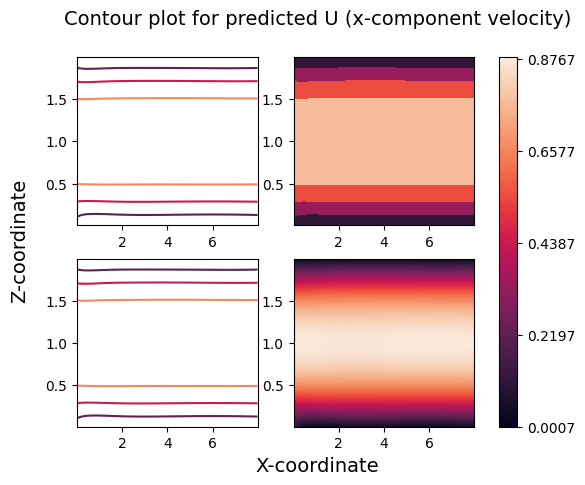

In [22]:
fig, ax = plt.subplots(2,2)
cmap_U_pred = []
levels = np.linspace(torch.min(y_pred[:,0:1].detach()),torch.max(y_pred[:,0:1].detach()),5) # Contour levels

# Overview
cmap_U_pred.append(ax[0,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels,cmap=sns.cm.rocket))
cmap_U_pred.append(ax[0,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels,cmap=sns.cm.rocket))

# Boundary layer initiation (zoomed in version)
cmap_U_pred.append(ax[1,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=levels,cmap=sns.cm.rocket))

cmap_U_pred.append(ax[1,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,0].detach().numpy(),levels=121,cmap=sns.cm.rocket))

# Figure format
fig.suptitle("Contour plot for predicted U (x-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
fig.colorbar(cmap_U_pred[3],ax=ax.ravel().tolist(),ticks=levels)
# fig.tight_layout()
plt.show()

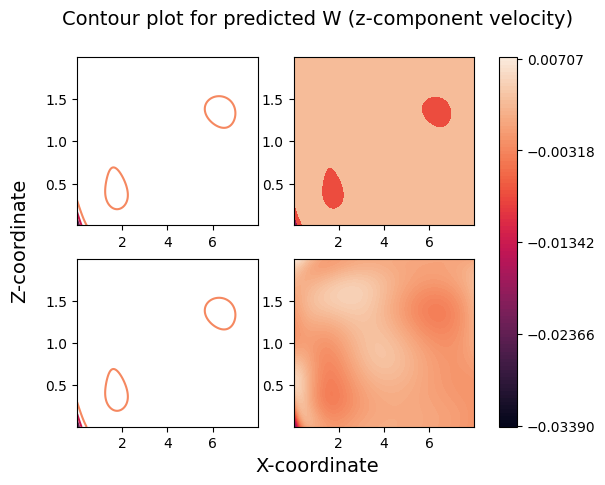

In [23]:
fig, ax = plt.subplots(2,2)
cmap_W_pred = []
levels = np.linspace(torch.min(y_pred[:,1:2].detach()),torch.max(y_pred[:,1:2].detach()),5) # Contour levels

# Overview
cmap_W_pred.append(ax[0,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels,cmap=sns.cm.rocket))
cmap_W_pred.append(ax[0,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels,cmap=sns.cm.rocket))

# Boundary layer initiation (zoomed in version)
cmap_W_pred.append(ax[1,0].tricontour(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=levels,cmap=sns.cm.rocket))
cmap_W_pred.append(ax[1,1].tricontourf(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),y_pred[:,1].detach().numpy(),levels=121,cmap=sns.cm.rocket))

# Figure format
fig.suptitle("Contour plot for predicted W (z-component velocity)",fontsize=14)
fig.supxlabel("X-coordinate",fontsize=14)
fig.supylabel("Z-coordinate",fontsize=14)
fig.colorbar(cmap_W_pred[3],ax=ax.ravel().tolist(),ticks=levels)
plt.show()